Necessary Improts

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

Data Loading and Preprocessing

In [93]:
df = pd.read_csv("Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250603.csv")
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
df = df.sort_values("Date")

In [94]:
df.columns

Index(['Date', 'Local Route', 'Light Rail', 'Peak Service', 'Rapid Route',
       'School', 'Other'],
      dtype='object')

In [95]:

service_cols = [
    "Local Route",
    "Light Rail",
    "Peak Service",
    "Rapid Route",
    "School",
    "Other"
]

df["Total_Journeys"] = df[service_cols].sum(axis=1)

df = df.set_index("Date")


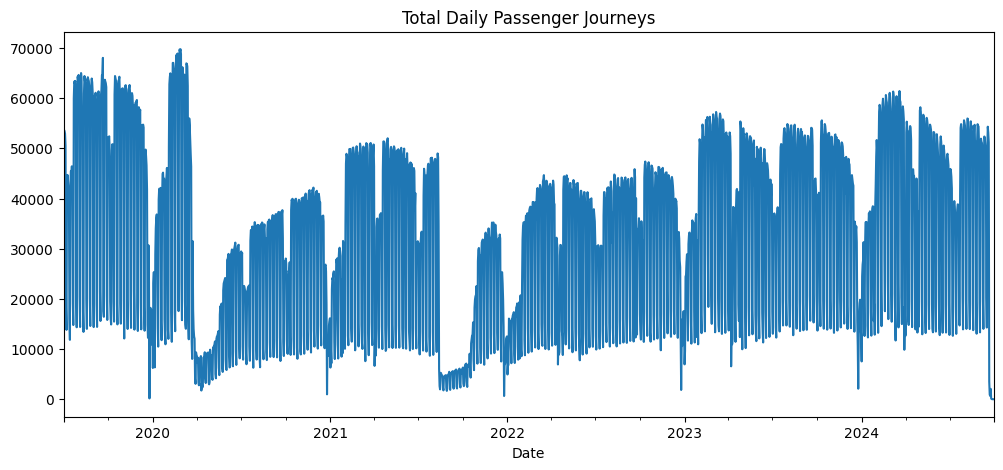

In [96]:
df["Total_Journeys"].plot(figsize=(12,5), title="Total Daily Passenger Journeys")
plt.show()

Decomposing Time Series with the period of 7 days

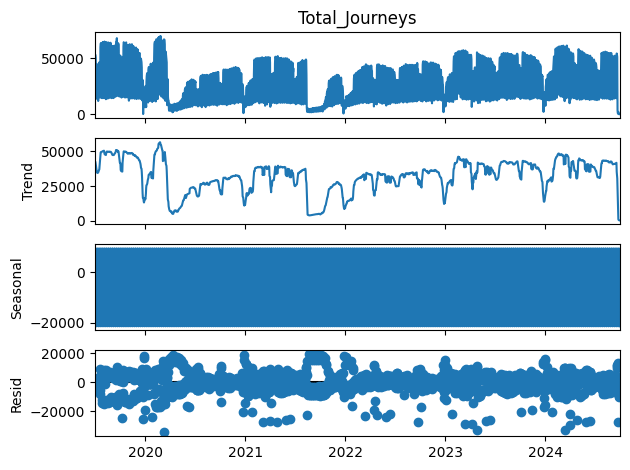

In [97]:
decomp = seasonal_decompose(
    df["Total_Journeys"],
    model="additive",
    period=7
)
decomp.plot()
plt.show()

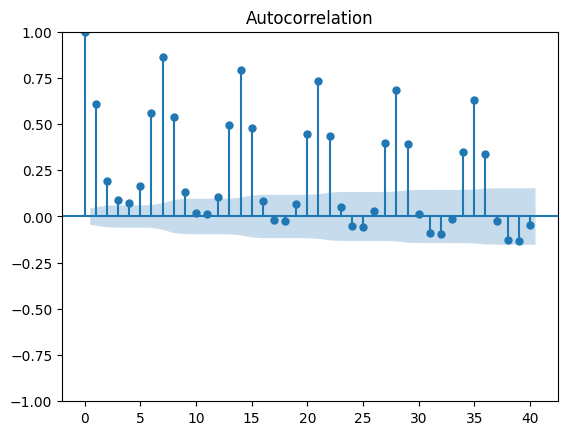

In [98]:
plot_acf(df["Total_Journeys"].dropna(), lags=40)
plt.show()



In [99]:
df["log"] = np.log1p(df["Total_Journeys"])
df["diff"] = df["Total_Journeys"].diff()
df["log_diff"] = df["log"].diff()
df["smooth_7"] = df["Total_Journeys"].rolling(7, min_periods=1).mean()


Train and testing the data 

In [100]:
train = df.iloc[:-30]
test = df.iloc[-30:]

SARIMA Model fitting and Forecasting

In [ ]:
model = SARIMAX(
    train["Total_Journeys"],
    order=(1,1,1),
    seasonal_order=(1,1,1,7)
)

res = model.fit()
print(res.summary())

                                     SARIMAX Results                                     
Dep. Variable:                    Total_Journeys   No. Observations:                 1888
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -19322.358
Date:                           Wed, 10 Dec 2025   AIC                          38654.716
Time:                                   12:00:06   BIC                          38682.387
Sample:                               07-01-2019   HQIC                         38664.910
                                    - 08-30-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2896      0.032      9.184      0.000       0.228       0.351
ma.L1         -0.8439      0.020    -42.877

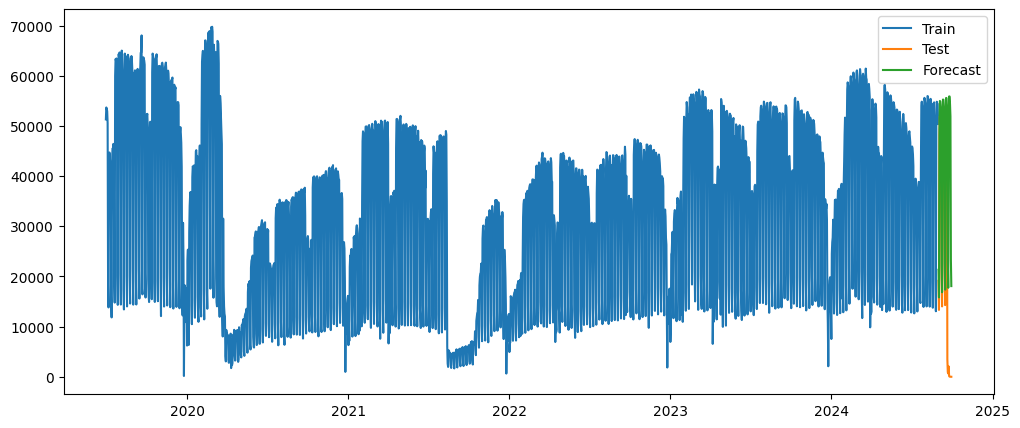

In [102]:
forecast = res.predict(
    start=test.index[0],
    end=test.index[-1]
)

plt.figure(figsize=(12,5))
plt.plot(train["Total_Journeys"], label="Train")
plt.plot(test["Total_Journeys"], label="Test")
plt.plot(forecast, label="Forecast")
plt.legend()
plt.show()

Evaluation of the Model

In [103]:
mae = mean_absolute_error(test["Total_Journeys"], forecast)
rmse = np.sqrt(mean_squared_error(test["Total_Journeys"], forecast))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 14703.748137161656
RMSE: 24628.519599676914
